In [1]:
# Try to create a mathematical model for the spatial structure of TMS
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

legend_font = 18
label_font = 24
title_font = 28


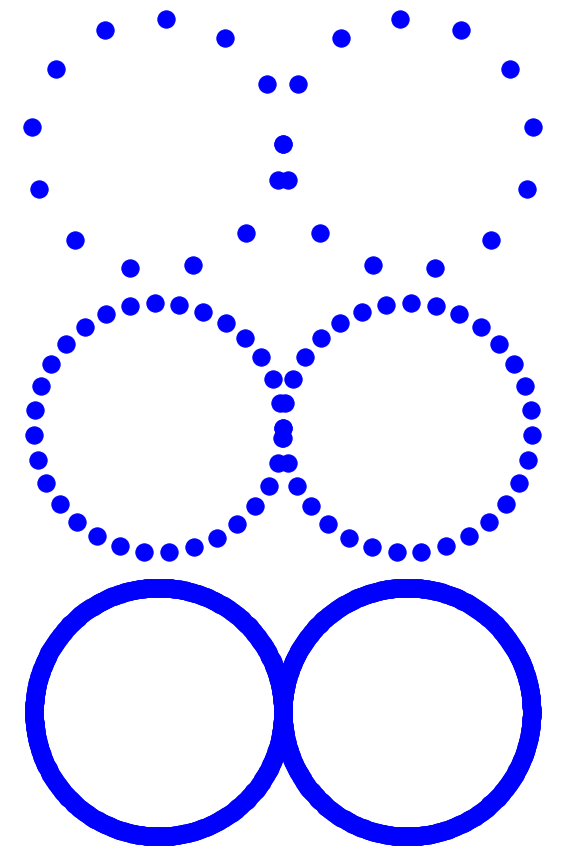

In [2]:
# Define the spatial resolution [mm]
#  it appears the TVB connectivity is described in mm
dxs = [0.5, 0.2, 0.01]
# dxs = [0.1]
# Define the coil radius (N. Lang et al. 2006)
r_coil = 0.05
r_coil = 1

fig, axes = plt.subplots(len(dxs), 1, figsize=(8, 12))
for i, dx in enumerate(dxs):
    # Define the coil circle and figure 8 data points
    n_pts = 2 * np.pi * r_coil / dx
    data_pts = np.arange(0, 2 * np.pi, dx)
    circ_xs = r_coil * np.cos(data_pts)
    circ_ys = r_coil * np.sin(data_pts)
    circ_zs = np.zeros(circ_xs.size)
    circ_coil_pts = np.stack((circ_xs, circ_ys, circ_zs)).T
    fig8_xs = np.hstack((r_coil * (np.cos(data_pts - np.pi) + 1), r_coil * (np.cos(data_pts) - 1)))
    fig8_ys = np.hstack((r_coil * np.sin(data_pts), r_coil * np.sin(data_pts)))
    fig8_zs = np.zeros(fig8_xs.size)
    fig8_coil_pts = np.stack((fig8_xs, fig8_ys, fig8_zs)).T

    # To actually apply the stimulus to the model, I need a function that
    #  takes a node or surface position and calculates the electric field
    #  strength at that point, relative to the coil. So I need to rotate
    #  the coil, and then calculate the node's position parallel to that
    #  plane, then I can use this Gaussian circle shape to calculated the
    #  strength at that point.

    axes[i].scatter(fig8_xs, fig8_ys, c='b', s=300)
#     axes[i].scatter(fig8_xs, fig8_ys, c='b', s=3000, alpha=0.2)
    axes[i].set_aspect('equal')
    axes[i].axis('off')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# axes[0].set_title('Coil Approximation', fontsize=title_font)
fig.tight_layout()

# plt.plot(circ_xs, circ_ys, '-o')
# plt.plot(fig8_xs, fig8_ys, '-o')


In [3]:
def field_strength(nodes, coil_pts, fig8=False):
    """ Calculates the strength of the electric field for a particular point
    
    The strength is calculated using a simple inverse square assumption of electric
    field strength. Since the points used to define the coil are equidistant, the
    total field strength at a particular point relative to this is defined as the
    normalized sum of distance from each point defining the coil. This assumes the TMS
    coil produces a homogeneous electric field (ref validity).
    *** Should be able to show that equidistant points is an integral in limit
    
    *** Will probably have to include some kind of transformation/rotation to define coil position
    This can be done in the code, rather than in this function. Since this is a linear transformation,
    a single transformation matrix should suffice. I can make a function that will return this matrix,
    given the desired position and orientation of the coil. Should also be able to define a function
    which returns a transformation matrix of the required rotation/tranlation for maximizing the
    stimulation strength of a particular area (maybe? maybe not required).
    
    *** Doesn't account for the direction of the electric field, and treats field as being uniform.
    
    Parameters
        nodes = coordinates of points being acted on by the electric field
                 dims = (n_nodes, 3), where second dimension is (x, y, z)
        coil_pts = discretized coordinates of the TMS coil
                    dims = (n_pts, 3), where second dimension is (x, y, z)
        fig8 = boolean indicating whether coil is a figure-8 type
    """
    
    # Define the number of nodes being calculated for
    try:
        n_nodes = nodes.shape[0]
    except AttributeError:
        n_nodes = 1
    # Define number of coil points (used for normalization)
    if fig8:
        n_pts = coil_pts.shape[0] / 4
    else:
        n_pts = coil_pts.shape[0]
    # Initialize strength of stimulus
    stim_strength = np.zeros(n_nodes)
    
    for i in range(n_nodes):
        stim_strength[i] += np.mean(1 / np.linalg.norm(nodes[i, :] - coil_pts, axis=1)**2) / n_pts
        
    return stim_strength
    

In [4]:
# Define a grid of test points
all_xs = np.arange(-3, 3+dx, dx)
all_ys = np.arange(-3, 3+dx, dx)
grid_pts = np.meshgrid(all_xs, all_ys)
grid_xs = grid_pts[0].flatten()
grid_ys = grid_pts[1].flatten()
grid_zs = 0.2 * np.ones(grid_xs.size)
pt_coords = np.vstack((grid_xs, grid_ys, grid_zs)).T
# print(pt_coords.shape)

# Calculate field strengths for test points
# circ_field = field_strength(pt_coords, circ_coil_pts, False)
# fig8_field = field_strength(pt_coords, fig8_coil_pts, True)
circ_field = field_strength(pt_coords, circ_coil_pts, False).reshape(grid_pts[0].shape)
fig8_field = field_strength(pt_coords, fig8_coil_pts, True).reshape(grid_pts[0].shape)


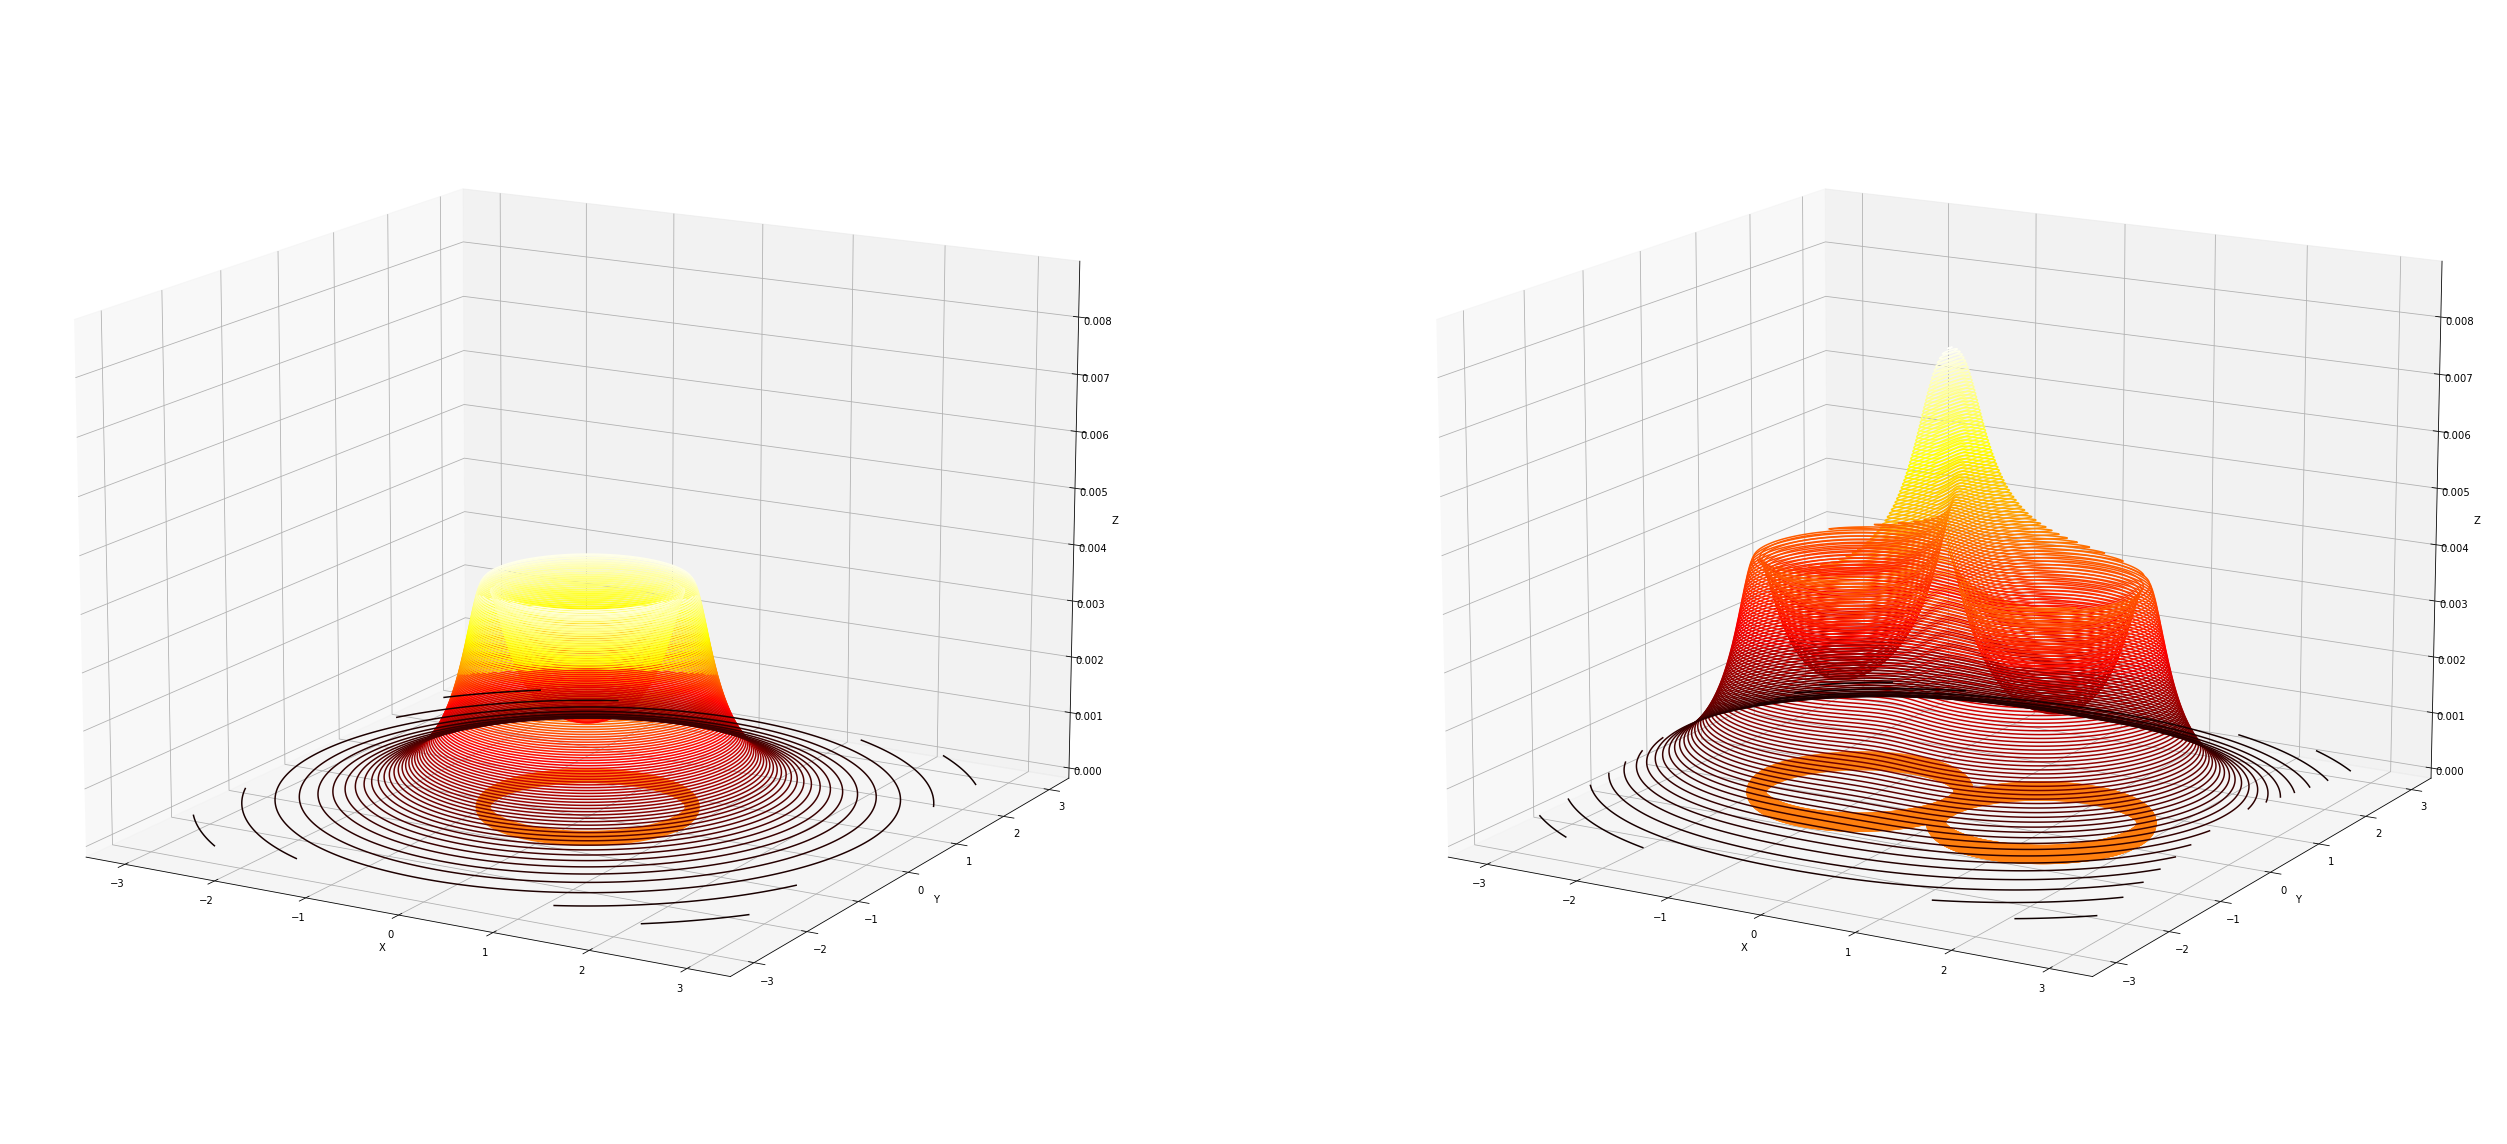

In [5]:
# Plot the field shapes
# fig = plt.figure(figsize=(16, 6))
fig = plt.figure(figsize=plt.figaspect(0.4)*4)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# ax1.contour3D(grid_pts[0], grid_pts[1], circ_field, 100, cmap='jet')
ax1.contour3D(grid_pts[0], grid_pts[1], circ_field, 100, cmap='hot')
# ax1.contour3D(grid_pts[0], grid_pts[1], circ_field, 100, cmap='winter')
# ax1.contour3D(grid_pts[0], grid_pts[1], circ_field, 100, cmap='gnuplot')
# ax1.contour3D(grid_pts[0], grid_pts[1], circ_field, 100, cmap='Blues')
ax1.plot(circ_xs, circ_ys, circ_zs, c='C1', linewidth=15)
ax1.view_init(15)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_zlim(0, 1.1 * np.max(fig8_field))

# ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field, 150, cmap='jet')
ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field, 150, cmap='hot')
# ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field, 150, cmap='winter')
# ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field, 150, cmap='gnuplot')
# ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field, 150, cmap='Blues')
ax2.scatter(fig8_xs, fig8_ys, fig8_zs, c='C1', linewidth=15)    
ax2.view_init(15)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_zlim(0, 1.1 * np.max(fig8_field))

# ax1.scatter(grid_xs, grid_ys, circ_field, c=circ_field, cmap='jet')    
# ax1.scatter(circ_xs, circ_ys, circ_zs, c='C1')
# ax1.set_ylim(-2.2, 2.2)
# # ax1.set_xlim(-1.2, 1.2)
# ax2.scatter(grid_xs, grid_ys, fig8_field, c=fig8_field, cmap='jet')    
# ax2.scatter(fig8_xs, fig8_ys, fig8_zs, c='C1')    
# ax2.set_ylim(-2.2, 2.2)

fig.tight_layout();


In [6]:
# Plot field strength at different distances from the coil

# Define a grid of test points
dx_grid = 0.01
all_xs = np.arange(-3, 3+dx_grid, dx_grid)
all_ys = np.arange(-3, 3+dx_grid, dx_grid)
n_pts = all_xs.size
grid_pts = np.meshgrid(all_xs, all_ys)
grid_xs = grid_pts[0].flatten()
grid_ys = grid_pts[1].flatten()

# Set distances from coil
z_dists = np.linspace(0.2, 0.6, 4)
circ_field_test = np.zeros((z_dists.size, n_pts, n_pts))
fig8_field_test = np.zeros((z_dists.size, n_pts, n_pts))
grid_zs_test = np.zeros((z_dists.size, n_pts, n_pts))
max_z = 0
for i, z in enumerate(z_dists):
    # Calculate the fields
    grid_zs = z * np.ones(grid_xs.size)
    grid_zs_test[i, :, :] = grid_zs.reshape(grid_pts[0].shape)
    pt_coords_test = np.vstack((grid_xs, grid_ys, grid_zs)).T
    circ_field_test[i, :, :] = field_strength(pt_coords_test, circ_coil_pts, False).reshape(grid_pts[0].shape)
    fig8_field_test[i, :, :] = field_strength(pt_coords_test, fig8_coil_pts, True).reshape(grid_pts[0].shape)
    max_z = max(max_z, np.max(fig8_field_test[i, :, :]))
    

In [7]:
print(all_xs.size)

601


/Applications/tvb-2.4.1.app/Contents/Resources/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


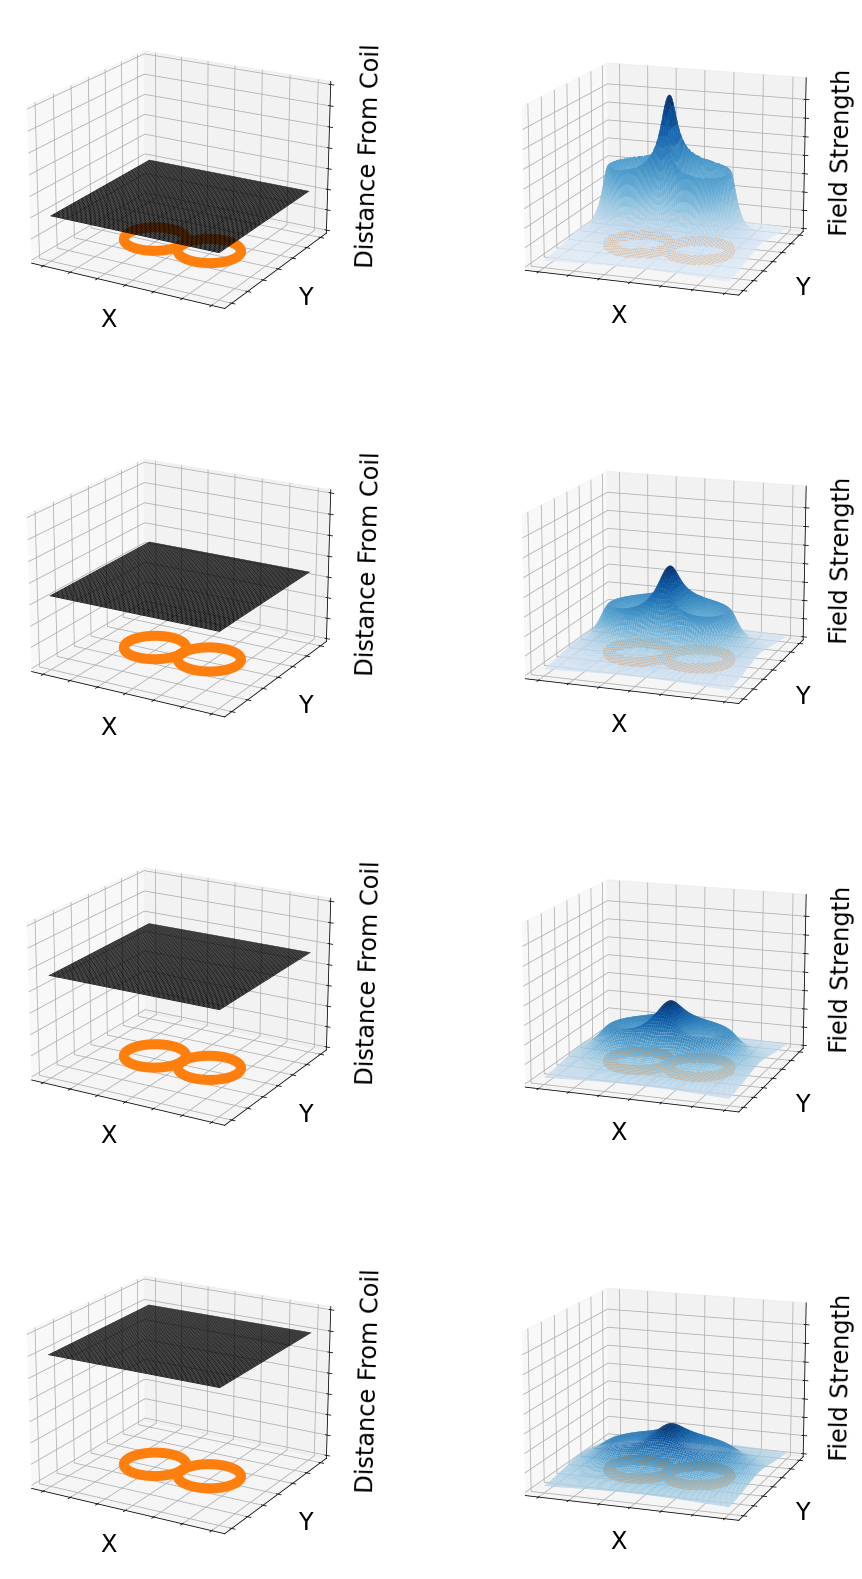

In [8]:
fig = plt.figure(figsize=plt.figaspect(1.8)*4)
s_cnt = 100
# # Create light source object.
# ls = LightSource()
# shd = ls.hillshade(35)
for i, z in enumerate(z_dists):
    # Plot the fields
    ax1 = fig.add_subplot(4, 2, 2*i+1, projection='3d', elev=20)
    ax2 = fig.add_subplot(4, 2, 2*i+2, projection='3d', elev=15, azim=-70)
#     ax2 = fig.add_subplot(4, 2, 2*i+2, projection='3d', elev=20)
    
# #     ax1.contour3D(grid_pts[0], grid_pts[1], circ_field_test[i, :, :], 60, cmap='hot', vmax=1.1*max_z)
# #     ax1.plot_wireframe(grid_pts[0], grid_pts[1], circ_field_test[i, :, :], 0.1, linewidth=1)
#     ax1.plot_surface(grid_pts[0], grid_pts[1], circ_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='Blues', vmin=-0.1*max_z)
# #     ax1.plot_surface(grid_pts[0], grid_pts[1], circ_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='hot', vmax=1.1*max_z)
# #     ax1.plot_surface(grid_pts[0], grid_pts[1], circ_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, lightsource=shd)
#     ax1.plot(circ_xs, circ_ys, circ_zs, c='C1', linewidth=10)
#     ax1.view_init(20)
    ax1.set_xlabel('X', fontsize=label_font)
    ax1.set_ylabel('Y', fontsize=label_font)
#     ax1.set_zlabel('Field Strength', fontsize=label_font)
#     ax1.set_zlim(0, max_z)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
#     ax1.set_axis_off()
#     ax1.set_frame_on(False)
    # Plot plane instead
    ax1.plot(fig8_xs, fig8_ys, fig8_zs, c='C1', linewidth=10)
#     ax1.plot_surface(grid_pts[0], grid_pts[1], grid_zs_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='Blues', vmin=-0.1*max_z)
    ax1.plot_surface(grid_pts[0], grid_pts[1], grid_zs_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='Greys', vmin=-0.1*max_z)
    ax1.set_zlabel('Distance From Coil', fontsize=label_font)
    ax1.set_zlim(0, 0.7)

#     ax2.contour3D(grid_pts[0], grid_pts[1], fig8_field_test[i, :, :], 100, cmap='hot', vmax=1.1*max_z)
#     ax2.plot_wireframe(grid_pts[0], grid_pts[1], fig8_field_test[i, :, :], 0.1, linewidth=1)
    ax2.plot_surface(grid_pts[0], grid_pts[1], fig8_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='Blues', vmin=-0.1*max_z)
#     ax2.plot_surface(grid_pts[0], grid_pts[1], fig8_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, cmap='hot', vmax=1.1*max_z)
#     ax2.plot_surface(grid_pts[0], grid_pts[1], fig8_field_test[i, :, :], rcount=s_cnt, ccount=s_cnt, lightsource=shd)
    ax2.scatter(fig8_xs, fig8_ys, fig8_zs, c='C1', linewidth=5)    
#     ax2.view_init(20)
    ax2.set_xlabel('X', fontsize=label_font)
    ax2.set_ylabel('Y', fontsize=label_font)
    ax2.set_zlabel('Field Strength', fontsize=label_font)
    ax2.set_zlim(0, max_z)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
#     ax2.set_axis_off()

fig.tight_layout();

# https://matplotlib.org/3.2.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html?highlight=wireframe#mpl_toolkits.mplot3d.axes3d.Axes3D.plot_wireframe
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.colors.LightSource.html#matplotlib.colors.LightSource.hillshade
# https://www.google.com/search?q=how+to+use+lightsource+python&oq=how+to+use+lightsource+python&aqs=chrome..69i57.3820j0j4&sourceid=chrome&ie=UTF-8
